# Finding relatives from their pictures using a Siamese network

* A Siamese network is used here to find the people who are relatives from a single picture from each person. The Concept is explained by professor Andrew NG in this video   

https://www.youtube.com/watch?v=0NSLgoEtdnw


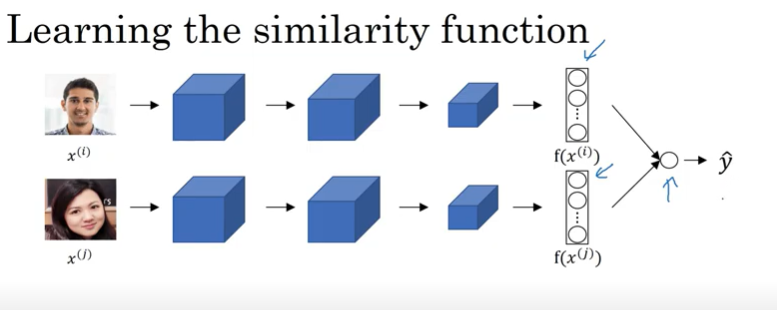

* The network is trained on the Northeastern university SMILE lab dataset called "Recognizing Faces in the Wild". Here is a link to the dataset: 
https://www.kaggle.com/c/recognizing-faces-in-the-wild/data

* The overall performance achieved is about ~75% validation accuracy after the network has been trained for 20000 batches of size 64. Here is the accuracy ( over a 100 randomly selected pictures who were on average 50% related) vs the epoch graph obtained. 


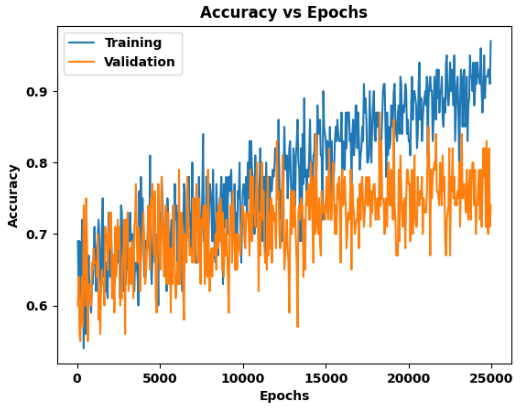

* The key obsticle in implementing this code was the need to take an absolute of the subtraction of the tensors after they pass through the common part of the netwrok and before entering the final nueron. If this abs or square function is not used the network can not be trained. 

# Due to the size of the memory and operations needed, the Kaggle environment could not be used to run this code and the PyCharm software was used Instead. 

# Imports

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import pandas as pd
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam

# Function to create a batch of data for training

In [ ]:
def get_batch(x, y, z, w, batch_size=64):
    rand_indexes_1 = []
    batch_x = []
    batch_y = np.zeros(batch_size)
    batch_x.append(np.zeros((batch_size, 224, 224, 3))) # final size is (2, batch_size, 224, 224, 3)
    batch_x.append(np.zeros((batch_size, 224, 224, 3)))
    ran_values = np.random.randint(0,2, (1,batch_size)) # Random value which determines whether to chose from relatives or not so that batches are balanced
    rand_indexes_0 = np.random.choice(range(0, len(x)), batch_size, replace=False)  # Random Indexes for choseing the first half of pics
    for ind_batchy in range(0, batch_size):  # Creating the 2nd half of pictures either from relatives or non-relatives
        if ran_values[0][ind_batchy] > 0.5:
            rand_indexes_1.append(int(np.random.choice(w[rand_indexes_0[ind_batchy]], 1, replace=False)))
        else:
            rand_indexes_1.append(int(np.random.choice(range(0, len(x)), 1, replace=False)))
    rand_indexes_1 = np.asarray(rand_indexes_1)
    batch_x[0] = x[rand_indexes_0]
    batch_x[1] = x[rand_indexes_1]
    for ind_batch in range(0, batch_size): # Creating labels for the batches of pictures
        if y[rand_indexes_0[ind_batch]][0] == y[int(rand_indexes_1[ind_batch])][0]:
            if (y[rand_indexes_0[ind_batch]][1] in z[y[int(rand_indexes_1[ind_batch])][0]][y[int(rand_indexes_1[ind_batch])][1]]) or (y[rand_indexes_0[ind_batch]][1] == y[int(rand_indexes_1[ind_batch])][1]):
                batch_y[ind_batch] = 1
            else:
                batch_y[ind_batch] = 0
        else:
            batch_y[ind_batch] = 0
    return (batch_x, batch_y)

# Function to test the performance on a set of data

In [ ]:
def nway_one_shot(model, x, y, z, w, tries=100):

    pics = []
    pics.append(np.zeros((1, 224, 224, 3)))
    pics.append(np.zeros((1, 224, 224, 3)))
    result = np.zeros((tries))   # holds the results of the predictions
    rand_family = np.zeros((tries)) # Random number to chose the pair from the same family ot not
    relat = np.zeros((tries)) # the correct label value of whether the pictures are actually related
    num_correct = 0
    accuracy = 0
    for comp_ind in range(0, tries):
        random_num1 = np.random.randint(0, x.shape[0] - 1)
        random_num2 = np.random.randint(0, x.shape[0] - 1)
        pics[0][:] = x[random_num1]
        rand_family[comp_ind] = np.random.randint(0,2, 1)
        if rand_family[comp_ind] > 0.5:
            random_num2 = int(np.random.choice(w[random_num1], 1, replace=False))
        pics[1][:] = x[random_num2]
        result[comp_ind] = siamese_net.predict(pics)
        if y[random_num1][0] == y[random_num2][0]:
            if (y[random_num1][1] in z[y[random_num2][0]][y[random_num2][1]]) or (y[random_num1][1] == y[random_num2][1]):
                relat[comp_ind] = 1
            else:
                relat[comp_ind] = 0
        else:
            relat[comp_ind] = 0
        if relat[comp_ind] == int(result[comp_ind] > 0.5):
            num_correct += 1
    accuracy = num_correct / tries
    df_result = pd.DataFrame(result)
    print('Standard deviation of the results is', df_result.describe().loc['std'])
    print('Percent correct =', accuracy * 100)
    return accuracy, result, relat

# Importing the images and labels

In [ ]:
base_dir = r'../Kaggle/recognizing_faces_in_the_wild'
families_directory = os.path.join(base_dir, 'train')
families = os.listdir(families_directory)
families_lists_directory = os.path.join(base_dir, 'test-public-lists')
familiy_lists = os.listdir(families_lists_directory)

x = []
y = []
z = {}
w = {}
ind_counter = 0
last_counter = 0

for family in families:
    z[int(family[1:])] = {}
    last_counter = ind_counter
    for relative in os.listdir(os.path.join(families_directory, family)):
        relative_dir = os.path.join(families_directory, family)
        z[int(family[1:])][int(relative[3:])] = []
        pic_counter = 0
        for pic in os.listdir(os.path.join(relative_dir, relative)):
            pic_dic = os.path.join(relative_dir, relative)
            x.append(np.asarray(Image.open(os.path.join(pic_dic, pic)).convert('RGB')))
            y.append([int(family[1:]), int(relative[3:]), pic_counter])
            w[ind_counter] = []
            for ind_pic in range(last_counter, ind_counter):
                w[ind_pic].append(ind_counter)
            for ind_pic in range(last_counter, ind_counter + 1):
                w[ind_counter].append(ind_pic)
            pic_counter += 1
            ind_counter += 1

#for file_name in familiy_lists:
#related = pd.read_csv(os.path.join(families_lists_directory, file_name))
related = pd.read_csv(os.path.join(base_dir, 'train_relationships.csv'))
for ind in range(0, len(related)):
    try:
        z[int(related.iloc[ind]['p1'].split('/')[0][1:])][int(related.iloc[ind]['p1'].split('/')[1][3:])].append(int(related.iloc[ind]['p2'].split('/')[1][3:]))
        z[int(related.iloc[ind]['p1'].split('/')[0][1:])][int(related.iloc[ind]['p2'].split('/')[1][3:])].append(int(related.iloc[ind]['p1'].split('/')[1][3:]))
    except:
        print('ind ', ind, ' was not resolved')

x = np.asarray(x)/255.0

# Plotting sample of Images

In [ ]:
#Plotting Images
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x[np.random.randint(0, x.shape[0]-1)])
plt.show()

# Building the model

In [ ]:
#Building a sequential model
input_shape = (224, 224, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean=0.0, stddev=1e-2)
b_init = keras.initializers.RandomNormal(mean=0.5, stddev=1e-2)

model = keras.models.Sequential([
    keras.layers.Conv2D(64, (16, 16), activation='relu', input_shape=input_shape, kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (8, 8), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(128, (4, 4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Conv2D(256, (4, 4), activation='relu', kernel_initializer=W_init, bias_initializer=b_init, kernel_regularizer=l2(2e-4)),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu', kernel_initializer=W_init, bias_initializer=b_init),
    keras.layers.Dense(512, activation='relu', kernel_initializer=W_init, bias_initializer=b_init),
    keras.layers.Dense(64, activation='relu', kernel_initializer=W_init, bias_initializer=b_init)
])

encoded_l = model(left_input)
encoded_r = model(right_input)
L1_layer = Lambda(lambda tensor: K.abs(tensor[0] - tensor[1])) # Getting the L1 Distance between the 2 encodings
subtracted = L1_layer([encoded_l, encoded_r]) # Add the distance function to the network
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)

optimizer = Adam(learning_rate=0.00003)
siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)

# Training the model

In [ ]:
epochs = 20000
batch_size = 64

loss_list = []
accuracy_list = []
for epoch in range(1, epochs):
    batch_x, batch_y = get_batch(x, y, z, w, batch_size)
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch, loss))
    if epoch%50 == 0:
        print('Epoch:', epoch, ', Loss:', loss)
        print("=============================================")
        accuracy, results, related = nway_one_shot(model, x, y, z, w, 100)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")


# Plotting the accuracy vs epochs

In [ ]:
accuracy_list_np = np.array(accuracy_list)
fig = plt.figure()
plt.plot(accuracy_list_np[:, 0], accuracy_list_np[:, 1])
plt.title("Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
fig.show()